# Classification: Resampling Techniques for Imbalanced Data - Completed

Imbalanced data is a very common issue that can sometimes cause huge problems for classifier performance. By "imbalanced", we mean that one or more classes is significantly under-represented in the dataset. Sometimes this is fully expected given the domain of the problem at hand - for example, if you were analysing a transaction dataset looking for credit card fraud, you would probably expect to see *many* more instances labelled "not fraud" than "fraud".

Unfortunately, there is no golden gun solution to this problem, but various different strategies have been developed for improving model performance in such cases. You can simply try different algorithms as some are better suited to imbalanced data, you can extend algorithms to assign distinct costs to training examples and thereby give different weights to classes, you can try ensemble methods, or you can try manipulating the datasets itself.

At the data level in particular, there are a few **resampling** techniques that try to balance the classes a little better. We will discuss these in this notebook, as well as their implementation in `imbalanced-learn` or `imblearn`. We will then return to the customer churn problem we tackled in the Introduction work (which used an imbalanced dataset) and see some of these ideas in practice - along the way we will introduce the concept of ROC curves, which are a powerful tool commonly used in classifier evaluation.

### Source Data: Creating an Imbalanced Dataset

In [1]:
# import the usual libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

To synthesise some data to illustrate these techniques, we can use the `sklearn.datasets.make_classification` class - this is a fairly simple construction that produces normally distributed clusters some specified distance apart, which you can read about in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) if you are interested. 

Let's create a binary dataset with 10000 data points, 2 features, a 99:1 class imbalance, and some slight noise (set via the `flip_y` argument) so that the dataset is not *perfectly* linearly separable (in which case an imbalance might not matter much anyway):

In [2]:
# import make_classification
from sklearn.datasets import make_classification

# construct a binary classification dataset with 2 features, 10000 instances, a 99:1 ratio and slight noise
X, y = make_classification(n_samples = 10000, n_classes = 2, n_features = 2, n_redundant = 0, 
                          n_clusters_per_class = 1, weights = [0.99], random_state = 40, flip_y = 0.001)

Note that we also set the `random_state` argument above as, without this, the above code will produce quite a different dataset each time it runs.

This function outputs X and y as `np.array`:

In [5]:
y

array([0, 0, 0, ..., 0, 0, 0])

Let's quickly check the class imbalance by converting y to a `pd.Series` and using `value_counts()`:

In [6]:
# check the class imbalance
pd.Series(y).value_counts()

0    9896
1     104
dtype: int64

Let's combine features and class into a pandas dataframe:

In [7]:
# combine X and y into a pandas dataframe
df = pd.DataFrame(data = X, columns = ['feature_1', 'feature_2'])
df['class'] = pd.Series(y)

In [10]:
# check the head of the data
df.head()

,feature_1,feature_2,class
0,1.560315,1.123360,0
1,-1.067693,0.951703,0
2,-0.954865,1.060890,0
3,1.459379,0.907493,0
4,1.711474,1.031483,0


Let's plot our data on a scatterplot, with `hue` given by the class:

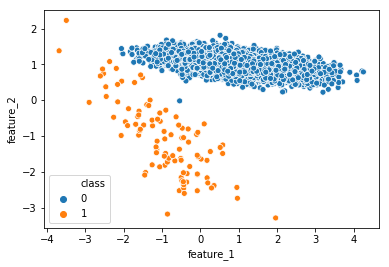

In [11]:
# produce a scatterplot of the 2 features with hue given by the class
sns.scatterplot(x = df['feature_1'], y = df['feature_2'], hue = df['class'])

### Random Undersampling

The first resampling technique we will demonstrate is called **random undersampling** - this consists of simply reducing the instances in the majority class (which for us is class 1 - "positive" class) by randomly removing some instances, thereby balancing the dataset to a certain degree.

> All of the resampling techniques we will use in this notebook have implementations in the `imbalanced-learn` or `imblearn` library (which is somewhat modelled after `sklearn`) - if you do not currently have it installed, you should install it using pip via a command like `pip install imbalanced-learn`.

Let's implement random undersampling using `RandomUnderSampler` and see how it affects our data. The main argument we want to set is the `sampling_strategy` argument which can take on a number of values as described in the [documentation](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler) - for us, we will just set it to a float which will represent the ratio of minority to majority classes after the resampling. All resampling techniques have their own issues, and so you are unlikely to use them to completely balance the classes in practice - we will pick ratio values that are somewhere in the middle throughout.

In [12]:
# import the function
from imblearn.under_sampling import RandomUnderSampler

# create a RandomUnderSampler that will finish with a 10:1 ratio of classes, and fix the random state
rus = RandomUnderSampler(sampling_strategy = 0.1, random_state = 123)

# fit the resampler to our dataset and store it into new variables
X_undersamp, y_undersamp = rus.fit_resample(X, y)

Let's now reproduce the previous steps of converting this data into a `pandas` dataframe and producing a scatterplot using `seaborn`:

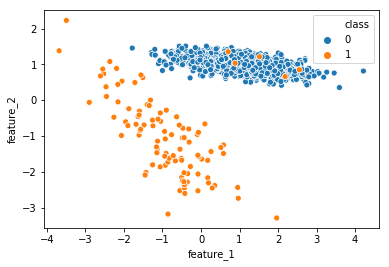

In [13]:
# convert the data to a dataframe, rename the target as "class", and plot a scatterplot
df = pd.DataFrame(data = X_undersamp, columns = ["feature_1", "feature_2"])
df['class'] = pd.Series(y_undersamp)

sns.scatterplot(x = df['feature_1'], y = df['feature_2'], hue = df['class'])

As is hopefully clear, the majority class (blue) has fewer instances compared to before, so much so in fact that we can actually see some minority class (orange) instances poking through in the middle of the blue cluster, which were hidden before. 

We can check that this has indeed left the minority class alone and simply reduced the majority class by checking the class imbalance again:

In [14]:
df['class'].value_counts()

0    1040
1     104
Name: class, dtype: int64

The main advantage of undersampling is that, especially for large datasets, it can reduce both processing time and storage demands by reducing the number of training examples. However, the main issue with this is that instances might be discared that contain potentially useful information for building the classifiers - the remaining sample is chosen randomly, and so there is no guarantee that it is a representative sample of the population, which may lead to bad generalisation.

### Random Oversampling

A contrasting approach is known as **random oversampling** - this randomly duplicates certain instances in the minority class, in order to try and balance the classes a bit. We can implement this using `RandomOverSampler`, which takes the same arguments as `RandomUnderSampler` as you can see in the [documentation](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler).

In [18]:
# import the function
from imblearn.over_sampling import RandomOverSampler

# create a RandomOverSampler that will finish with a 10:1 ratio of classes, and fix the random state
ros = RandomOverSampler(sampling_strategy = 0.1, random_state = 123)

# fit the resampler to our dataset and store it into new variables
X_oversamp, y_oversamp = ros.fit_resample(X, y)

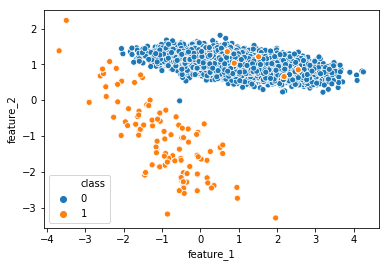

In [19]:
# convert the data to a dataframe, rename the target as "class", and plot a scatterplot
df = pd.DataFrame(data = X_oversamp , columns = ["feature_1", "feature_2"])
df['class'] = pd.Series(y_oversamp)

sns.scatterplot(x = df['feature_1'], y = df['feature_2'], hue = df['class'])

As we can see, the majority class has not been reduced at all, but some minority class instances have been duplicated - so much so that again we can see some poking through in the middle of majority class cluster in the plot above now.

We can check that oversampling has left the majority class alone, and has simply increased the number of minority class instances:

In [20]:
df['class'].value_counts()

0    9896
1     989
Name: class, dtype: int64

The main advantage of oversampling is that, unlike undersampling, this does not discared of any training instances and therefore does not risk losing valuable information for classifier building - for this reason it often performs better than undersampling. However, the duplication of minority class instances does increase the likelihood of *overfitting* and so runs the risk of poor generalisation.

### Synthetic Minority Oversampling Technique (SMOTE)

A more sophisticated oversampling technique than simple random oversampling was introduced in a 2002 [paper](https://arxiv.org/pdf/1106.1813.pdf) and utilises the idea of constructing new *synthetic* training examples for the minority class - for this reason the technique is called **synthetic minority oversampling technique (SMOTE)**.

SMOTE creates new synthetic minority instances by drawing *straight lines* between a minority instance and a certain number of nearest minority instance neighbours in feature space, and randomly placing new instances along one of these lines. We can implement it using `SMOTE` which again takes the same arguments as the previous two classes we have utilised.

In [21]:
# import the function
from imblearn.over_sampling import SMOTE

# create a RandomUnderSampler that will finish with a 10:1 ratio of classes, and fix the random state
smote = SMOTE(sampling_strategy = 0.1, random_state = 123)

# fit the resampler to our dataset and store it into new variables
X_smote, y_smote = smote.fit_resample(X, y)

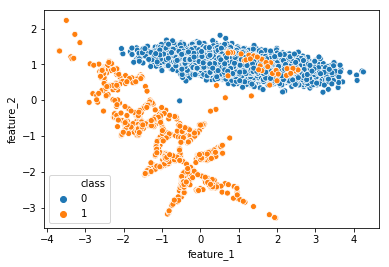

In [22]:
# convert the data to a dataframe, rename the target as "class", and plot a scatterplot
df = pd.DataFrame(data = X_smote, columns = ["feature_1", "feature_2"])
df['class'] = pd.Series(y_smote)

sns.scatterplot(x = df['feature_1'], y = df['feature_2'], hue = df['class'])

In [ ]:
df['class'].value_counts()

As with random oversampling, this does not risk losing valuable information, and moreover it reduces the risk of overfitting since it generates new synthetic examples rather than merely duplicating existing instances. However, the main problem is that while generating synthetic examples SMOTE does not take into consideration neighboring examples from other classes -  this can result in increase in overlapping of classes and can introduce additional noise as we can see from the above plot. SMOTE is also not very effective for high dimensional data.

### Pipelines

In the original [paper](https://arxiv.org/pdf/1106.1813.pdf) introducing SMOTE, it was suggested that SMOTE be preceeded by undersampling to first trim away some majority class instances - it was argued that this combination produced the best classifier performance. This can be efficiently implemented using `imblearn.pipeline` (which is modelled after `sklearn.pipeline` as will be briefly mentioned in the Online Practice).

In [25]:
# import the function
from imblearn.pipeline import Pipeline

# set up the undersampler and SMOTE oversampler so that we end up with a ratio of 10:1
undersampler = RandomUnderSampler(sampling_strategy = 0.05, random_state = 123)
oversampler = SMOTE(sampling_strategy = 0.1, random_state = 123)

# construct the resampling pipeline
pipe_steps = [('u', undersampler), ('o', oversampler)]
pipeline = Pipeline(steps = pipe_steps)

# apply the resampling pipeline to the data and store into new variables
X_pipe, y_pipe = pipeline.fit_resample(X, y)

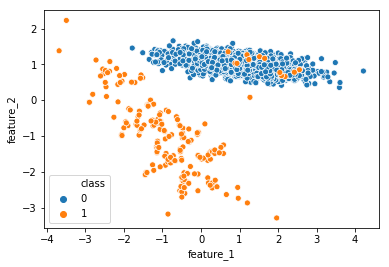

In [26]:
# convert the data to a dataframe, rename the target as "class", and plot a scatterplot
df = pd.DataFrame(data = X_pipe , columns = ["feature_1", "feature_2"])
df['class'] = pd.Series(y_pipe)

sns.scatterplot(x = df['feature_1'], y = df['feature_2'], hue = df['class'])

We can again check the class imbalance as usual:

In [27]:
df['class'].value_counts()

0    2080
1     208
Name: class, dtype: int64

Clearly we have ended up with less training data here, but the above plot is perhaps a more reasonable representation than that produced by SMOTE alone.

## Returning to our Customer Churn Problem

Let's recall our customer churn problem that we tackled in the Introduction work. Let's quickly reproduce the loading of data, cleaning, and preprocessing that performed there:

In [28]:
# read in the data
data = pd.read_csv("churn.csv")

# drop unhelpful columns
data = data.drop(['CustomerId', 'Surname', 'RowNumber'], axis = 1)

# make class names clearer
data['Exited'] = data['Exited'].replace([0,1], ['No', 'Yes'])

# split into features (X) and class (y)
X = data.drop('Exited', axis = 1)
y = data['Exited']

from sklearn.model_selection import train_test_split

# perform a train/test split using a 70:30 ratio and fixing the random seed to e.g. 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# perform one-hot encoding on X_train to handle categorical features
X_train = pd.get_dummies(X_train)

# preprocess the test set too
X_test = pd.get_dummies(X_test)

We can check that the train/test split has roughly produced the correct proportions of classes in the train and test sets (for severely imbalanced datasets this might not be the case, and you might need to try a **stratified** split instead):

In [29]:
y.value_counts()

No     7963
Yes    2037
Name: Exited, dtype: int64

In [30]:
y_train.value_counts()

No     5568
Yes    1432
Name: Exited, dtype: int64

In [31]:
y_test.value_counts()

No     2395
Yes     605
Name: Exited, dtype: int64

So indeed in this case we see that the class proportions are roughly preserved in the train and test sets.

We now want to rebuild our decision tree model and evaluate as we did in the Introduction work. As discussed previously, accuracy is not an appropriate measure to use for imbalanced data - other metrics like precision, recall, and f1-score are more suited. Another standard in classifier evaluation that is often used is given by the **ROC AUC** as we will now discuss.

### ROC Curves

We are studying a binary classification problem with 2 classes that are labelled "Yes" and "No". Recall that a prediction can be described as:

True positive: predicts "Yes" when actually "Yes"  
True negative: predicts "No" when actually "No"  
False positive: predicts "Yes" when actually "No"  
False negative: predicts "No" when actually "Yes"  

From this we can define the **true positive rate (TPR)**:

```TPR = # true positives / # positives```

and **false positive rate (FPR)**:

```FPR = # false positives / # negatives```

Clearly, we would ideally like our classifier to have a high TPR and a low FPR. This can be conveniently assessed visually from a **receiver operating characteristic (ROC) curve**, which is a plot of the TPR against the FPR for each possible value of the decision threshold (recall that this is the probability threshold used to decide whether or not an instance is in class A or class B, and *need* not always be 0.5). The ROC curve can be used to select the optimal choice of classification threshold, by finding the sweet spot where the TPR is high and the FPR is low, as we will demonstrate in the Online Practice.

Every ROC curve starts in the bottom-left and moves to the top-right of the curve. Why is this? For a classification threshold value of O, every "Yes" value is classified as "Yes" - thus, the TPR is 1. However, all the "No" values are also classified as "Yes", and so the FPR is also 1. As the threshold value increases, more and more "No" labels are assigned. Thus, the FPR and TPR both decrease - when the threshold reaches 1, no "Yes" labels are assigned, and the FPR and TPR are both 0. A high-performing classifier would have the TPR rapidly shoot up towards 1 across the lower range of FPR values - the closer the ROC curve traces along the vertical axis and approaches the upper-left hand of the plot, the better the classifier performs, since you will be able to find a good classification threshold (with high TPR and low FPR) as mentioned above. Thus, a useful metric to assess classifier performance in general is to compute the **area under the ROC curve (AUC)** - note that the theoretical maximum for the AUC is 1 since the TPR and FPR can range between 0-1. 

There is a nice visualisation of ROC curves [here](http://www.navan.name/roc/).

> For imbalanced datasets, the **precision-recall curve** is actually usually favoured to the ROC curve as the latter can give a slightly optimistic view of performance, mainly because the ROC curve is fairly insensitive to class balance - we will use the latter for now however, as the AUC gives a convenient way for us to measure the classifier performance whilst cross-validating (or at least, a better measure than the accuracy).

This can all be implemented using a couple of functions from the `sklearn.metrics` library. In particular, `roc_curve` computes the TPR and FPR for a variety of thresholds (which could then be plotted), and `auc` computes the area under the ROC curve. Let's illustrate it with a `LogisticRegression` classifier, a simple type of classifier you will learn a lot about in the Online Practice - we can setup and train the model in the usual `sklearn` way:

In [32]:
# import LogisticRegression
from sklearn.linear_model import LogisticRegression

# setup the model
model = LogisticRegression()

# fit the model to the training data
model.fit(X_train, y_train)

LogisticRegression()

In [34]:
# import roc_curve and auc
from sklearn.metrics import roc_curve, auc

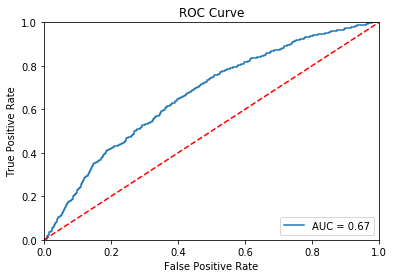

In [35]:
# use the model to simply generate the raw probabilities 
y_probs = model.predict_proba(X_test)

# extract the probabilities for the second class ("Yes")
preds = y_probs[:,1]

# given the probabilities and the true values, you can generate the roc_curve
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label = "Yes")

# compute the AUC
roc_auc = auc(fpr, tpr)

# plot the roc_curve with the AUC value in the legend
plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Evaluating our Imbalanced Classifier

Let's stick with a `LogisticRegression` classifier for now, since it doesn't require the extra complexity of grid-searching, and is known to handle imbalanced data badly so we will hopefully see a real improvement from resampling. We have seen the ROC curve for the original model above - we can further evaluate the model via the standard metrics:

In [36]:
# let's import all the usual metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [37]:
# evaluate all of the metrics on the test set
print("Original AUC: ", roc_auc)
print("Original accuracy: ", accuracy_score(y_test, model.predict(X_test)))
print("Original precision: ", precision_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Original recall: ", recall_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Original f1: ", f1_score(y_test, model.predict(X_test), pos_label = 'Yes'))

Original AUC:  0.6680046239583153
Original accuracy:  0.7886666666666666
Original precision:  0.32098765432098764
Original recall:  0.04297520661157025
Original f1:  0.07580174927113703


We see that the accuracy, and to some extent the AUC, are overly optimistic for imbalanced data but the other metrics give away the underlying issue - this classifier is performing terribly on the other metrics demonstrating how badly the model is performing for the "Yes" class.

Now let's try our resampling combination of undersampling and SMOTE. Note that we never resample the **test set** that we are evaluating our model on - this would change the balance of classes, which is unrepresentative of new data that our classifier will be predicting on when it is deployed.

In [38]:
# set up the undersampler and SMOTE oversampler
under = RandomUnderSampler(sampling_strategy = 0.4, random_state = 1)
over = SMOTE(sampling_strategy = 0.8, random_state = 1)

# construct the pipeline
steps = [('u', under), ('o', over)]
pipeline = Pipeline(steps = steps)

# reample the data using the pipeline
X_pipe, y_pipe = pipeline.fit_resample(X_train, y_train)

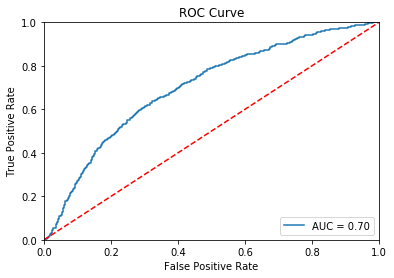

In [39]:
# setup the model
model = LogisticRegression()

# fit the model to the resampled data
model.fit(X_pipe, y_pipe)

# use the model to simply generate the raw probabilities 
y_probs = model.predict_proba(X_test)

# extract the probabilities for the second class ("Yes")
preds = y_probs[:,1]

# given the probabilities and the true values, you can generate the roc_curve
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label = 'Yes')

# compute the AUC
roc_auc = auc(fpr, tpr)

# plot the roc_curve with the AUC value in the legend
plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
# again evaluate all of the metrics on the test set
print("Resampled AUC: ", roc_auc)
print("Resampled accuracy: ", accuracy_score(y_test, model.predict(X_test)))
print("Resampled precision: ", precision_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Resampled recall: ", recall_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Resampled f1: ", f1_score(y_test, model.predict(X_test), pos_label = 'Yes'))

Resampled AUC:  0.7014275608619887
Resampled accuracy:  0.7076666666666667
Resampled precision:  0.3547008547008547
Resampled recall:  0.5487603305785124
Resampled f1:  0.4308890330953926


In [ ]:
# compute the confusion matrix
print(confusion_matrix(y_test, model.predict(X_test)))

Other than a slight drop in accuracy, this leads to a dramatic improvement in performance on the whole (though clearly still far from perfect performance).

### Using Decision Trees

Let's now repeat this analysis using decision trees, like we originally did in the Introduction work. Decision trees are actually inherently better at handling imbalanced data, but we can check to see if we can still get any model improvement.

Strictly speaking, we should repeat the grid search to choose our hyperparameter values when performing resampling, since the dataset will be altered. This introduces some extra complexity, since it is preferrable to use **stratified** k-folds when cross-validating, so that the class balances are preserved in each fold - we leave this as optional stretch material. For now, we will simply choose the "best" tree we found from the Introduction, which you might recall had `criterion = 'gini'` and `max_depth = 5`, and see if resampling improves the performance at all.

In [41]:
# import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

In [42]:
# setup the tree model with critetion = 'gini' and max_depth = 5
model = DecisionTreeClassifier(criterion = 'gini', max_depth = 5)

# fit the model to the training data
model.fit(X_train, y_train)

# generate the probabilities 
y_probs = model.predict_proba(X_test)

# extract the probabilities for the second class ("Yes")
preds = y_probs[:,1]

# generate the roc_curve
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label = 'Yes')

# compute the AUC
roc_auc = auc(fpr, tpr)

# compute the metrics on the test set
print("Original AUC: ", roc_auc)
print("Original accuracy: ", accuracy_score(y_test, model.predict(X_test)))
print("Original precision: ", precision_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Original recall: ", recall_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Original f1: ", f1_score(y_test, model.predict(X_test), pos_label = 'Yes'))

Original AUC:  0.8304411739332977
Original accuracy:  0.8045602605863192
Original precision:  0.8045602605863192
Original recall:  0.40826446280991735
Original f1:  0.5416666666666666


Now let's repeat our resampling pipeline and evaluate again:

In [43]:
# setup the undersample and SMOTE oversampler
under = RandomUnderSampler(sampling_strategy = 0.3, random_state = 1)
over = SMOTE(sampling_strategy = 0.6, random_state = 1)

# construct the pipeline
steps = [('u', under), ('o', over)]
pipeline = Pipeline(steps = steps)

# run the pipeline
X_pipe, y_pipe = pipeline.fit_resample(X_train, y_train)

# setup the model
model = DecisionTreeClassifier(criterion = 'gini', max_depth = 5)

# fit the model to the resampled data
model.fit(X_pipe, y_pipe)

# calculate the probabilities
y_probs = model.predict_proba(X_test)

# extract the probabilities for the second class
preds = y_probs[:,1]

# generate the roc_curve
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label = 'Yes')

# compute the AUC
roc_auc = auc(fpr, tpr)

print("Resampled AUC: ", roc_auc)
print("Resampled accuracy: ", accuracy_score(y_test, model.predict(X_test)))
print("Resampled precision: ", precision_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Resampled recall: ", recall_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Resampled f1: ", f1_score(y_test, model.predict(X_test), pos_label = 'Yes'))

Resampled AUC:  0.8452009178902328
Resampled accuracy:  0.8596666666666667
Resampled precision:  0.6974248927038627
Resampled recall:  0.5371900826446281
Resampled f1:  0.6069094304388423


When we look it at like this we see that the classifier is performing quite differently: 

- The AUC is about the same
- The precision has dropped by about 10%
- The accuracy has improved by about 5%
- Notably, the recall has come up by about 13%
- Importantly, the f1-score has also come up by about 6%

There is no such thing as a free lunch, and these resampling techniques don't just solve the problem of imbalanced data for you - as expected from what we saw in the Introduction work, increasing the recall generally leads to a reduction in precision and vice versa, in line with the **precision-recall tradeoff** that we have mentioned previously. Depending on the case and the data at hand, these techniques can often improve classifier performance in the way that might matter to you for the problem you are solving, and so they are worth trying.

### Extra: Grid-searching with Decision Trees

Let's repeat the `GridSearchCV` we did in the Introduction work to find the hyperparameters, but with one slight difference. Rather than simply creating k-folds randomly, we will create **stratified** folds so that the class proportions are maintained in each fold. This can be implemented using the `RepeatedStratifiedKFold` class from `sklearn` which can then be passed as the `cv` argument in `GridSearchCV`, rather than passing a simple integer as we did before (to specify the number of folds).

In [44]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [45]:
# define the parameter grid
param_grid = [
        {'criterion': ['gini', 'entropy'], 
         'max_depth': [2, 5, 7, 9, 11]},
]

# setup the model with all arguments as default
model = DecisionTreeClassifier()

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

# pass the model, cv, and the param_grid to the grid search
grid_search = GridSearchCV(model, param_grid, cv = cv, scoring = 'roc_auc')

# fit the grid search to the training set
grid_search.fit(X_train, y_train)

# return the hyperparameter values of the best model
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 5}

Mean score (AUC) of best estimator from cross-validation:

In [46]:
grid_search.best_score_

0.8312239829343415

In [47]:
model = grid_search.best_estimator_

Let's see how it performs on the test set:

In [48]:
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)

# extract the probabilities for the second class
preds = y_probs[:,1]

# generate the roc_curve
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label = 'Yes')

# compute the AUC
roc_auc = auc(fpr, tpr)

print("Test set AUC: ", roc_auc)

Test set AUC:  0.8472492624096344


so there is very similar performance on train and test. We can summarise the classifier performance more fully by looking at the precision, recall and f1-score:

In [49]:
print("Original AUC: ", roc_auc)
print("Original accuracy: ", precision_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Original precision: ", precision_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Original recall: ", recall_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Original f1: ", f1_score(y_test, model.predict(X_test), pos_label = 'Yes'))

Original AUC:  0.8472492624096344
Original accuracy:  0.7563025210084033
Original precision:  0.7563025210084033
Original recall:  0.4462809917355372
Original f1:  0.5613305613305614


#### Using Resampling

Now let's try our combination of undersampling and SMOTE. Note that we never resample the **test set** that we are evaluating our model on - this would change the balance of classes, which is unrepresentative of new data that our classifier will be predicting on when it is deployed.

In [50]:
under = RandomUnderSampler(sampling_strategy = 0.3, random_state = 1)
over = SMOTE(sampling_strategy = 0.6, random_state = 1)

steps = [('u', under), ('o', over)]
pipeline = Pipeline(steps = steps)

X_pipe, y_pipe = pipeline.fit_resample(X_train, y_train)

Let's now repeat the grid search with our resampled training set:

In [51]:
# define the parameter grid
param_grid = [
        {'criterion': ['gini', 'entropy'], 
         'max_depth': [2, 5, 7, 9, 11]},
]

# setup the model with all arguments as default
model = DecisionTreeClassifier()

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

# pass the model and the param_grid to the grid search
grid_search = GridSearchCV(model, param_grid, cv = cv, scoring = 'roc_auc')

# fit the grid search to the training set
grid_search.fit(X_pipe, y_pipe)

# return the hyperparameter values of the best model
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 7}

Mean score (AUC) of best estimator from cross-validation:

In [52]:
grid_search.best_score_

0.8792965809366213

and so see that this score has gone up a bit.

In [53]:
model = grid_search.best_estimator_

Let's see how it performs on the **test set** however (which recall is totally "new" data that was not resampled at all, and so retains the original class imbalance):

In [54]:
model.fit(X_pipe, y_pipe)

X_test = pd.get_dummies(X_test)
y_probs = model.predict_proba(X_test)

# extract the probabilities for the second class
preds = y_probs[:,1]

# generate the roc_curve
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label = 'Yes')

# compute the AUC
roc_auc = auc(fpr, tpr)

print("Test set AUC: ", roc_auc)

Test set AUC:  0.8393001949654066


So in fact the performance is very similar from the point of view of the AUC. We can see exactly how our classifier is performing differently now by looking at the various metrics:

In [55]:
print("Resampled AUC: ", roc_auc)
print("Resampled accuracy: ", accuracy_score(y_test, model.predict(X_test)))
print("Resampled precision: ", precision_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Resampled recall: ", recall_score(y_test, model.predict(X_test), pos_label = 'Yes'))
print("Resampled f1: ", f1_score(y_test, model.predict(X_test), pos_label = 'Yes'))

Resampled AUC:  0.8393001949654066
Resampled accuracy:  0.8416666666666667
Resampled precision:  0.6094276094276094
Resampled recall:  0.5983471074380166
Resampled f1:  0.603836530442035


We see a similar story to what we found with the best tree from the Introduction work that we used before - a slight drop in precision, but an increase in recall and f1-score.

**Ensemble methods**, which you will learn about in your next Classification module, are another way to improve performance for imbalanced data, and sometimes a combination of resampling techniques and ensemble methods are the best strategy.